### Le but est d'utiliser la méthode SIFT couplé avec des méthodes d'apprentissage supervisé pour distinguer quatre espèces de chiens: **Chihuahua, Japanese spaniel, Maltese dog et le Pekinese**

# Features-matching

## Principe de fonctionnement du features-matching


Les algorithmes de **features-matching** procèdent en trois étapes : la **détection des points-clés**, la **description** et le **match**.

In [41]:
#Module utilisé

import cv2
import skimage
import skimage.io
import numpy as np
from skimage.transform import rescale
import pandas as pd


import glob

from sklearn import manifold

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import linear_model

import matplotlib.pyplot as plt

In [14]:
#Pour interagir facilement avec le drive

from google.colab import drive

drive.mount('/gdrive')

%cd /gdrive/My\ Drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [15]:
# Changer de version d'opencv

!pip install opencv-contrib-python==4.4.0.44

print (cv2.__version__)

4.4.0


# **Importation des données**

---

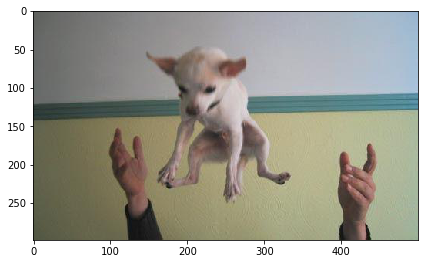

In [16]:
# téléchargement des bases de données d'images.

chihuahua=glob.glob("surf_dogs/n02085620-Chihuahua/*.jpg")
japanese=glob.glob("surf_dogs/n02085782-Japanese_spaniel/*.jpg")
maltesse=glob.glob("surf_dogs/n02085936-Maltese_dog/*.jpg")
pekinese=glob.glob("surf_dogs/n02086079-Pekinese/*.jpg")


skimage.io.imshow(chihuahua[0])

**La détection des points-clés**

Lorsqu'un humain observe  quelque chose (un visage, un animal, un objet...) il arrive à reconnaître l'objet dans différents contextes ou différentes scènes.

Cela suggère qu'en dépit de certains changements(scènes, photométriques, géométriques ...) que peut subir un objet d'une image à l'autre, on est en mesure de le reconnaître indépendamment de ces changements. Ainsi un certain nombre d'informations visuelles sur cet objet sont suffisantes pour le caractériser. Et c'est de là que vient le concept de points-clés. Ce sont les endroits de l'objet qui sont invariants lorsqu'on passe d'une image à l'autre image. Et donc sont suffisants pour le caractériser. La détection de points-clés consiste à trouver ces points-clés. **La détection de points-clés consiste à trouver ces points-clés.**

**La description des points-clés**

Une fois les points-clés trouvés il faut les décrire de sorte à ce que chacun d’eux garde
sa spécificité et qu’il soit exploitable par l’ordinateur, c’est l’étape de description.
des points-clés. En pratique pour caractériser un point-clé, on prend en compte son
voisinage. Ainsi, un descripteur de points-clés donne des informations non seulement
sur le point clé mais aussi un certain voisinage de ce point.

### **Détection et description des points-clés pour chaque groupe chiens**

---

In [17]:
def methode_sift(donnees):
  
  Sift=cv2.SIFT_create()# definiton d'un objet sift

  #représentation des points d'intérêts sur la première image
  img=skimage.io.imread(donnees[0])
  kp,desc=Sift.detectAndCompute(img,None)
  test = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  plt.imshow(test)
  plt.show()
 
  desc_full=[]
  
  for image in donnees:
    img=skimage.io.imread(image)
    kp,desc=Sift.detectAndCompute(img,None)
    for d in desc:
      desc_full.append(d)
    

  return desc_full
 

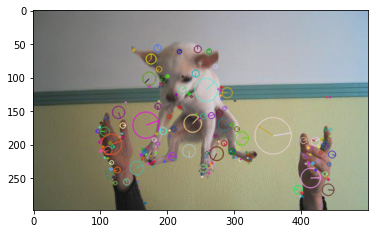

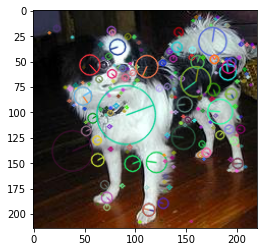

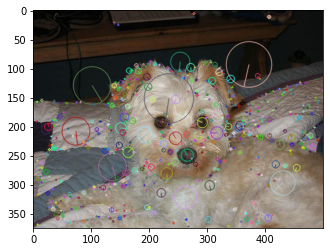

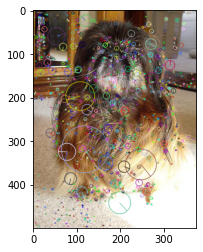

In [18]:
desc_chihuahua=methode_sift(chihuahua)

desc_japanese=methode_sift(japanese)

desc_maltesse=methode_sift(maltesse)

desc_pekinese=methode_sift(pekinese)


**Le matching**

Dans l'algorithme classique une fois les points-clés de l’objet détecté et décrit, il faut aussi détecter et dé-
crire les points de l’image dans laquelle on souhaite retrouver l’objet. Ensuite, on
passe à l’étape de matching. L’étape de matching consiste à trouver les meilleurs
correspondances entre les descripteurs de l’objet, et ceux de l’image où on souhaite
le retrouver, avec l’idée que les meilleurs correspondances seront les endroits de cette
dernière où l’objet se trouve.

In [19]:
#Transformation des données en dataset

data_chihuahua=pd.DataFrame(desc_chihuahua)

data_japanese=pd.DataFrame(desc_japanese)

data_maltesse=pd.DataFrame(desc_maltesse)

data_pekinese=pd.DataFrame(desc_pekinese)



### **Création des bags-of-features**

---

#### **création des visuals words: kmeans et wards**

---

In [20]:
def visualkmeans(donnees):
  kmeans=KMeans(n_clusters=5).fit(donnees)
  return kmeans.cluster_centers_

In [21]:
visual_chihuahua=visualkmeans(data_chihuahua)
visual_japanese=visualkmeans(data_japanese)
visual_maltesse=visualkmeans(data_maltesse)
visual_pekinese=visualkmeans(data_pekinese)

## **Création des bags-of-features:correspondances**



---

In [23]:
def bags(visual_words,donnees):
  bags=[]
  for image in donnees:
    img=skimage.io.imread(image)
    n=np.shape(img)[0]*np.shape(img)[1]
    i=0
    bags_image=[]
    for visual in visual_words:
      for a in visual:
        for b in img:
          if a.all()==b.all():
            i=i+1
      bags_image.append(i/n) 
    bags.append(bags_image) 

  return bags       

In [24]:
bags_chihuahua=bags(visual_chihuahua,chihuahua)
bags_japanese=bags(visual_japanese,japanese)
bags_maltesse=bags(visual_maltesse,maltesse)
bags_pekinese=bags(visual_pekinese,pekinese)

In [25]:
bags_chihuahua=pd.DataFrame(bags_chihuahua)
bags_japanese=pd.DataFrame(bags_japanese)
bags_maltesse=pd.DataFrame(bags_maltesse)
bags_pekinese=pd.DataFrame(bags_pekinese)


# **Projection dans un espace de rédescription des descripteurs des images chihuahua avec t-SNE**

---

In [51]:
bags_pekinese.shape

(147, 5)

In [50]:
bags_chihuahua=  bags_chihuahua.drop(columns=['y'])

bags_japanese=   bags_japanese.drop(columns=['y'])

bags_maltesse=   bags_maltesse.drop(columns=['y'])

bags_pekinese=   bags_pekinese.drop(columns=['y'])

In [68]:
bags_pekinese.shape

(147, 5)

## **Réorganisation et étiquettage des données**

---

In [69]:
y=pd.DataFrame(np.zeros((150)))
bags_chihuahua['y']=y

y=pd.DataFrame(np.zeros(183)+1)
bags_japanese['y']=y

y=pd.DataFrame(np.zeros(250)+2)
bags_maltesse['y']=y

y=pd.DataFrame(np.zeros(147)+3)
bags_pekinese['y']=y


In [75]:
A=bags_chihuahua.append(bags_japanese)
B=bags_maltesse.append(bags_pekinese)

tdonnees=A.append(B)
tdonnees.shape

(730, 6)

# **Classification avec la régression logistique**

---

In [73]:
tdonnees.head()

,0,1,2,3,4,y
0,0.249987,0.499973,0.749960,0.999946,1.249933,0.0
1,0.010474,0.020949,0.031423,0.041897,0.052372,0.0
2,0.089946,0.179892,0.269838,0.359784,0.449730,0.0
3,0.426667,0.853333,1.280000,1.706667,2.133333,0.0
4,0.119988,0.239976,0.359964,0.479952,0.599939,0.0


In [95]:
X=pd.DataFrame(tdonnees.iloc[:,[0,1,2,3,4]])
y=pd.DataFrame(tdonnees['y'])
x_train,x_test,y_train,y_test=train_test_split(X,y)

In [96]:
mod_logist=linear_model.LogisticRegression(solver='liblinear',multi_class='auto').fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [98]:
precision=mod_logist.score(x_test,y_test)
print(precision*100)

40.98360655737705
